# Lab | Series de tiempo

Repetir los análisis realizados en clase con los datos correspondientes a los años 2020, 2021
- Buscar los datos disponibles en la web:https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-de-peaje-ausa
- Explorar que las columnas sean iguales entre si
- Unir dataframes
- Graficar para detectar outliers
- Realizar análisis temporales de estacionalidad y comparar con los datos de 2017, 2018 y 2019
    - Horaria
    - Diaria
    - Semanal
    
 - Realizar gráficas de predicción con **prophet**

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
sns.set()

import datetime
from prophet import Prophet

c:\Users\Elsa\anaconda3\envs\IronHackTest\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [63]:
#Importo dataset del 2017 al 2019 limpio 
data_17_19= pd.read_csv('Data/illia_2017_2019.csv')

In [64]:
#Importo datasets 2020 y 2021 para limpiar:
data_2020 = pd.read_csv('Data/flujo-vehicular-2020.csv')

In [65]:
data_2021 = pd.read_csv('Data/flujo-vehicular-2021.csv',sep =',')

C:\Users\Elsa\AppData\Local\Temp\ipykernel_12828\3794458715.py:1: DtypeWarning: Columns (0,2,3,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data_2021 = pd.read_csv('Data/flujo-vehicular-2021.csv',sep =',')


In [66]:
data_2020.info()
data_2020.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678735 entries, 0 to 678734
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         678735 non-null  int64 
 1   fecha           678735 non-null  object
 2   mes             678735 non-null  object
 3   dia             678735 non-null  object
 4   dia_fecha       678735 non-null  int64 
 5   hora_inicio     678735 non-null  int64 
 6   hora_fin        678735 non-null  int64 
 7   estacion        678735 non-null  object
 8   tipo_vehiculo   678735 non-null  object
 9   forma_pago      678735 non-null  object
 10  observacion     678735 non-null  object
 11  sentido         678735 non-null  object
 12  cantidad_pasos  678735 non-null  int64 
dtypes: int64(5), object(8)
memory usage: 67.3+ MB


,periodo,fecha,mes,dia,dia_fecha,hora_inicio,hora_fin,estacion,tipo_vehiculo,forma_pago,observacion,sentido,cantidad_pasos
0,2020,2020-01-01,enero,Miércoles,1,0,1,ALBERDI,Auto,Efectivo,Efectivo,Centro,24
1,2020,2020-01-01,enero,Miércoles,1,0,1,ALBERDI,Auto,Efectivo,Efectivo,Provincia,80
2,2020,2020-01-01,enero,Miércoles,1,0,1,ALBERDI,Auto,Rec.Deuda,Paso en Infracción,Provincia,1
3,2020,2020-01-01,enero,Miércoles,1,0,1,ALBERDI,Auto,Rec.Deuda,Paso en infracción con Multa LPR,Centro,1
4,2020,2020-01-01,enero,Miércoles,1,0,1,ALBERDI,Auto,Rec.Deuda,Paso en infracción con Multa LPR,Provincia,1


In [67]:
#Vamos a limpiar el dataset de 2020 y 2021 para que quede acorde al de 2017-18-19

In [68]:
#Quitamos las columnas que no vamos a utilizar:
data_2020.drop(columns = ['periodo','mes','dia_fecha','hora_inicio','observacion'],inplace=True)

In [69]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora:
data_2020['fecha2'] = pd.to_datetime(data_2020.fecha) + pd.to_timedelta(data_2020.hora_fin, unit = 'h')

In [70]:
#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
data_2020.drop(columns=['fecha','hora_fin'], inplace = True)

In [71]:
data_2020.head()

,dia,estacion,tipo_vehiculo,forma_pago,sentido,cantidad_pasos,fecha2
0,Miércoles,ALBERDI,Auto,Efectivo,Centro,24,2020-01-01 01:00:00
1,Miércoles,ALBERDI,Auto,Efectivo,Provincia,80,2020-01-01 01:00:00
2,Miércoles,ALBERDI,Auto,Rec.Deuda,Provincia,1,2020-01-01 01:00:00
3,Miércoles,ALBERDI,Auto,Rec.Deuda,Centro,1,2020-01-01 01:00:00
4,Miércoles,ALBERDI,Auto,Rec.Deuda,Provincia,1,2020-01-01 01:00:00


In [72]:
print(data_2020['estacion'].unique())
print(data_2020['forma_pago'].unique())
print(data_2020['tipo_vehiculo'].unique())

['ALBERDI' 'AVELLANEDA' 'DELLEPIANE LINIERSLEPIANE CENTRO'
 'DELLEPIANE LINIERS' 'ILLIA' 'ILP' 'PB1' 'PB3' 'PB4' 'RETIRO' 'SALGUERO'
 'SARMIENTO' 'PB2']
['Efectivo' 'Rec.Deuda' 'Tarjeta Magnética' 'Tag' 'Exento' 'Violación'
 'CPP']
['Auto' 'Auto con trailer' 'Moto' 'N/D' 'Pago Doble Auto'
 'Pago Doble Auto con trailer / Pesado 2 Ejes' 'Pago doble Moto'
 'Pesados 2 Ejes' 'Pesados 3 Ejes' 'Pesados 4 Ejes' 'Pesados 5 Ejes'
 'Pesados 6 Ejes']


In [73]:
#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(data_2020.estacion=='ILLIA', data_2020.forma_pago == 'Efectivo')
data_2020 = data_2020[mask]

In [74]:
#Checkando los cambios:
data_2020.info()
print(data_2020['estacion'].unique())
print(data_2020['forma_pago'].unique())

<class 'pandas.core.frame.DataFrame'>
Index: 16716 entries, 52 to 633572
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   dia             16716 non-null  object        
 1   estacion        16716 non-null  object        
 2   tipo_vehiculo   16716 non-null  object        
 3   forma_pago      16716 non-null  object        
 4   sentido         16716 non-null  object        
 5   cantidad_pasos  16716 non-null  int64         
 6   fecha2          16716 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 1.0+ MB
['ILLIA']
['Efectivo']


In [75]:
 #Quitamos columnas "estación" y "forma_pago" ya no las necesitamos:
data_2020.drop(columns=['estacion','forma_pago'], inplace = True)

In [76]:
#Corregimos el nombre de fecha2 a fecha
data_2020.rename(columns = {'fecha2':'fecha'}, inplace = True) 
data_2020.head()

,dia,tipo_vehiculo,sentido,cantidad_pasos,fecha
52,Miércoles,Auto,Centro,326,2020-01-01 01:00:00
53,Miércoles,Auto,Provincia,319,2020-01-01 01:00:00
134,Miércoles,Auto,Centro,199,2020-01-01 02:00:00
135,Miércoles,Auto,Provincia,180,2020-01-01 02:00:00
202,Miércoles,Auto,Centro,114,2020-01-01 03:00:00


In [77]:
#Ordeno las columnas tal y cómo están en el dataset de 2017-18-19
new_order = ['dia','sentido','tipo_vehiculo','cantidad_pasos','fecha']
data_2020 = data_2020[new_order]

In [78]:
#Reordenamos el dataset por fecha
data_2020.sort_values('fecha', inplace = True)
data_2020.reset_index(drop=True, inplace = True)
data_2020

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Miércoles,Centro,Pesados 2 Ejes,1,2020-01-01 00:00:00
1,Miércoles,Provincia,Pesados 2 Ejes,3,2020-01-01 00:00:00
2,Miércoles,Provincia,Moto,6,2020-01-01 00:00:00
3,Miércoles,Centro,Moto,7,2020-01-01 00:00:00
4,Miércoles,Provincia,Auto,423,2020-01-01 00:00:00
...,...,...,...,...,...
16711,Jueves,Centro,Moto,32,2020-03-19 21:00:00
16712,Jueves,Provincia,Auto,550,2020-03-19 21:00:00
16713,Jueves,Provincia,Moto,5,2020-03-19 22:00:00
16714,Jueves,Centro,Auto,2,2020-03-19 22:00:00


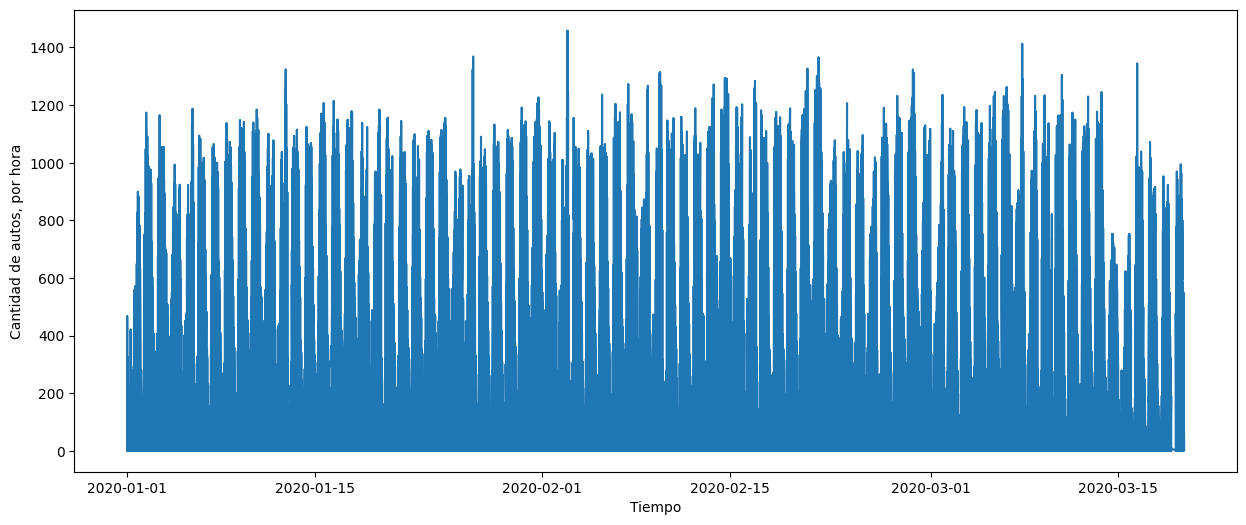

In [79]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(data_2020.fecha, data_2020.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [80]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = data_2020.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(79, 4)


,dia,sentido,tipo_vehiculo,cantidad_pasos
fecha,,,,
2020-01-01,MiércolesMiércolesMiércolesMiércolesMiércolesM...,CentroProvinciaProvinciaCentroProvinciaCentroP...,Pesados 2 EjesPesados 2 EjesMotoMotoAutoAutoPe...,21395
2020-01-02,JuevesJuevesJuevesJuevesJuevesJuevesJuevesJuev...,ProvinciaCentroProvinciaCentroCentroProvinciaP...,AutoAutoMotoMotoPesados 2 EjesPesados 2 EjesPe...,33722
2020-01-03,ViernesViernesViernesViernesViernesViernesVier...,CentroProvinciaProvinciaCentroProvinciaCentroP...,MotoMotoPago Doble AutoPesados 2 EjesPesados 2...,37067
2020-01-04,SábadoSábadoSábadoSábadoSábadoSábadoSábadoSába...,ProvinciaCentroProvinciaProvinciaProvinciaCent...,Auto con trailerMotoMotoAutoPesados 2 EjesPesa...,30627
2020-01-05,DomingoDomingoDomingoDomingoDomingoDomingoDomi...,ProvinciaCentroCentroProvinciaCentroCentroProv...,AutoAutoPesados 2 EjesPesados 2 EjesPesados 3 ...,27812


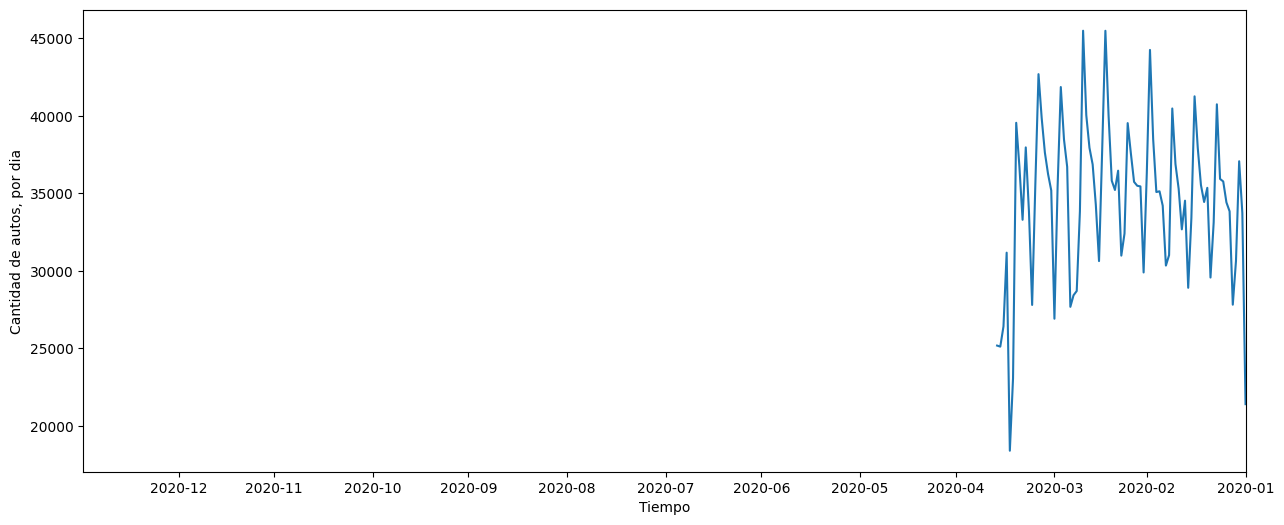

In [81]:
#Volvemos a graficar nuestra serie de tiempo, esta vez por día para el año 2020
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim(datetime.date(2020,12,31), datetime.date(2020,1,1))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [82]:
data_2020.fecha.value_counts()

fecha
2020-02-17 16:00:00    16
2020-02-10 11:00:00    14
2020-03-02 14:00:00    14
2020-02-14 12:00:00    14
2020-02-22 18:00:00    14
                       ..
2020-02-01 04:00:00     5
2020-03-17 02:00:00     5
2020-03-08 03:00:00     4
2020-03-18 03:00:00     4
2020-03-19 22:00:00     3
Name: count, Length: 1888, dtype: int64

- Vemos que no hay datos a partir de marzo, pues fue el año de la pandèmia de covid

In [83]:
#Vamos a ver con el dataset de 2021:
data_2021.info()
data_2021.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3029367 entries, 0 to 3029366
Data columns (total 10 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   Año de Fecha Operativa  object
 1   Cat Cobrada             object
 2   Día de Fecha Operativa  object
 3   Hora HH                 object
 4   ID Peaje                object
 5   Mes de Fecha Operativa  object
 6   Observacion             object
 7   Sentido                 object
 8   Tipo Cobro              object
 9   Pasos                   object
dtypes: object(10)
memory usage: 231.1+ MB


,Año de Fecha Operativa,Cat Cobrada,Día de Fecha Operativa,Hora HH,ID Peaje,Mes de Fecha Operativa,Observacion,Sentido,Tipo Cobro,Pasos
0,2021,Auto,1,0,ALB,abril,Efectivo,Provincia,Efectivo,7
1,2021,Auto,1,0,ALB,abril,Mercado Pago,Provincia,Mercado Pago,4
2,2021,Auto,1,0,ALB,abril,Mercado Pago OCR,Centro,Mercado Pago,1
3,2021,Auto,1,0,ALB,abril,Paso en infracción con Multa LPR,Provincia,Rec.Deuda,1
4,2021,Auto,1,0,ALB,abril,Tag - PosPago,Centro,Tag,19


In [84]:
#Inspección de variables
print(data_2021['Cat Cobrada'].unique())
print(data_2021['ID Peaje'].unique())
print(data_2021['Observacion'].unique())
print(data_2021['Tipo Cobro'].unique())

['Auto' 'Auto con trailer' 'Moto' 'N/D' 'Pago doble Moto' 'Pesados 2 Ejes'
 'Pesados 3 Ejes' 'Pesados 4 Ejes' 'Pesados 5 Ejes' 'Pesados 6 Ejes'
 'Total' 'Pago Doble Auto con trailer / Pesado 2 Ejes' 'Pago Doble Auto']
['ALB' 'AVE' 'DEC' 'DEL' 'ILL' 'ILP' 'PB1' 'PB2' 'PB3' 'PB4' 'RET' 'SAL'
 'SAR' 'Total']
['Efectivo' 'Mercado Pago' 'Mercado Pago OCR'
 'Paso en infracción con Multa LPR' 'Tag - PosPago' 'Tag - PosPago OCR'
 'Exento - Reglamento' 'Paso en Infracción' 'T.Magnética Disc.'
 'Violación - Normal' 'Exento - Otros motivos' 'Tag - Exento'
 'Exento - Demora en cobro' 'Tag - PrePago OCR'
 'Paso en Infracción con Multa' 'Violación - Rebote'
 'Metrobus no hab. TAG pospago' 'Metrobus no hab. OCR pospago'
 'Metrobus no hab. TAG Mercado Pago' 'Paso a facturar - (colectivo)'
 'Violación - Repetitiva' 'Metrobus no hab. OCR Mercado Pago'
 'Tag - PrePago' 'Violación - Via Liberada' 'Violación - Vía Cerrada'
 'Total' 'Metrobus no hab. TAG prepago' 'Metrobus no hab. OCR prepago'
 'Obs CPP']
[

In [85]:
#año de fecha operativa + día de fecha operativa + mes de fecha operativa (para crear datetime ?¿)
#Id peaje: ILL = Illia 
#observacion y tipo de cobro = forma pago (dropear columna observación)
#Pasos = cantidad_pasos
#Cat cobrada == tipo de vehiculo?¿


In [86]:
#Quitamos las columnas que no vamos a utilizar:
data_2021.drop(columns = ['Observacion'],inplace=True)

In [87]:
data_2021.rename(columns={'Cat Cobrada':'tipo_vehiculo'}, inplace=True)

In [88]:
data_2021.rename(columns={'Pasos':'cantidad_pasos'}, inplace=True)

In [89]:
data_2021.rename(columns={'Sentido':'sentido'}, inplace=True)

In [90]:
#Vamos a crear la columna fecha en formato datetime:
# Diccionario para asignar nombres de meses a sus respectivos números
month_mapping = {
    'enero': '01',
    'febrero': '02',
    'marzo': '03',
    'abril': '04',
    'mayo': '05',
    'junio': '06',
    'julio': '07',
    'agosto': '08',
    'septiembre': '09',
    'octubre': '10',
    'noviembre': '11',
    'diciembre': '12'
}

In [91]:
# Asignar nombres de meses a números
data_2021['Mes de Fecha Operativa'] = data_2021['Mes de Fecha Operativa'].map(month_mapping)

In [92]:
# Asegurarnos de que todas las partes de la concatenación sean strings
data_2021['Año de Fecha Operativa'] = data_2021['Año de Fecha Operativa'].astype(str)
data_2021['Día de Fecha Operativa'] = data_2021['Día de Fecha Operativa'].astype(str)
data_2021['Hora HH'] = data_2021['Hora HH'].astype(str)
data_2021['Mes de Fecha Operativa'] = data_2021['Mes de Fecha Operativa'].astype(str)

In [93]:
# Filtrar filas no válidas
valid_rows = data_2021[
    data_2021['Año de Fecha Operativa'].str.isdigit() &
    data_2021['Día de Fecha Operativa'].str.isdigit() &
    data_2021['Hora HH'].str.isdigit() &
    data_2021['Mes de Fecha Operativa'].str.isdigit()
].copy() 
# Copia para evitar el SettingWithCopyWarning


In [94]:
# Combinar las columnas para tener el string en el formato datetime
valid_rows['datetime'] = valid_rows['Año de Fecha Operativa'] + '-' + valid_rows['Mes de Fecha Operativa'] + '-' + valid_rows['Día de Fecha Operativa'] + ' ' + valid_rows['Hora HH'] + ':00:00'

In [95]:
valid_rows['datetime'] = pd.to_datetime(valid_rows['datetime'], format='%Y-%m-%d %H:%M:%S')

In [96]:
print(valid_rows.dtypes)

Año de Fecha Operativa            object
tipo_vehiculo                     object
Día de Fecha Operativa            object
Hora HH                           object
ID Peaje                          object
Mes de Fecha Operativa            object
sentido                           object
Tipo Cobro                        object
cantidad_pasos                    object
datetime                  datetime64[ns]
dtype: object


In [97]:
data_2021 = valid_rows

In [98]:
#Dropeamos columnas que ya no necesitamos:
data_2021.drop(columns=['Año de Fecha Operativa','Día de Fecha Operativa','Hora HH','Mes de Fecha Operativa'], inplace = True)

In [99]:
data_2021.rename(columns={'datetime':'fecha'}, inplace=True)

In [100]:
#Añado la columna dia con el nombre del dia de la semana tal y como aparece en los otros dataframes
data_2021['dia'] = data_2021['fecha'].dt.day_name()

In [101]:
#Creo un diccionario para traducirlos:
day_translation = {
    'Monday': 'Lunes',
    'Tuesday': 'Martes',
    'Wednesday': 'Miércoles',
    'Thursday': 'Jueves',
    'Friday': 'Viernes',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}

In [102]:
data_2021['dia'] = data_2021['dia'].map(day_translation)

In [103]:
#Cambio los nombres para facilitar la mask
data_2021.rename(columns={'ID Peaje':'id'}, inplace=True)

In [104]:
data_2021.rename(columns={'Tipo Cobro':'cobro'}, inplace=True)

In [105]:
#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(data_2021.id=='ILL', data_2021.cobro == 'Efectivo')
data_2021 = data_2021[mask]

In [106]:
#De nuevo dropeamos las que no necesitamos y las reordenamos:
data_2021.drop(columns=['id','cobro'], inplace = True)

C:\Users\Elsa\AppData\Local\Temp\ipykernel_12828\2106481828.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2021.drop(columns=['id','cobro'], inplace = True)


In [107]:
#Ordeno las columnas tal y cómo están en el dataset de 2017-18-19
new_order = ['dia','sentido','tipo_vehiculo','cantidad_pasos','fecha']
data_2021 = data_2021[new_order]

In [108]:
#Reordenamos el dataset por fecha
data_2021.sort_values('fecha', inplace = True)
data_2021.reset_index(drop=True, inplace = True)
data_2021

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Viernes,Provincia,Moto,3,2021-01-01 00:00:00
1,Viernes,Centro,Moto,6,2021-01-01 00:00:00
2,Viernes,Provincia,Auto,76,2021-01-01 00:00:00
3,Viernes,Centro,Auto,111,2021-01-01 00:00:00
4,Viernes,Centro,Pesados 2 Ejes,2,2021-01-01 00:00:00
...,...,...,...,...,...
53853,Viernes,Provincia,Moto,10,2021-12-31 19:00:00
53854,Viernes,Provincia,Auto,264,2021-12-31 19:00:00
53855,Viernes,Centro,Auto,264,2021-12-31 19:00:00
53856,Viernes,Provincia,Pesados 2 Ejes,2,2021-12-31 19:00:00


In [109]:
data_2021['cantidad_pasos'] = pd.to_numeric(data_2021['cantidad_pasos'], errors='coerce')

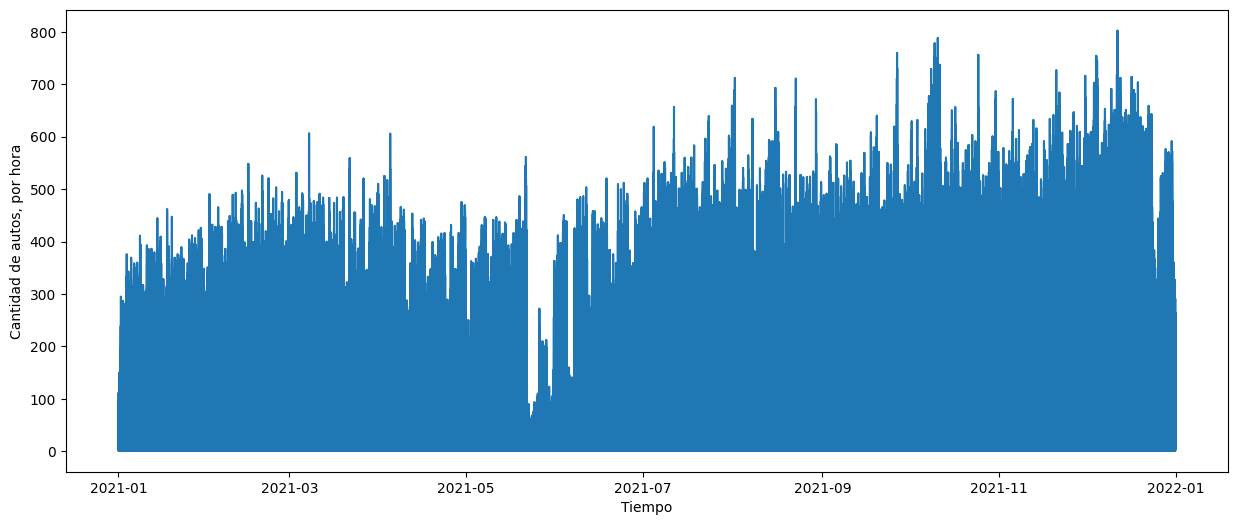

In [110]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(data_2021.fecha, data_2021.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [111]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = data_2021.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(365, 4)


,dia,sentido,tipo_vehiculo,cantidad_pasos
fecha,,,,
2021-01-01,ViernesViernesViernesViernesViernesViernesVier...,ProvinciaCentroProvinciaCentroCentroCentroProv...,MotoMotoAutoAutoPesados 2 EjesMotoMotoAutoAuto...,5788
2021-01-02,SábadoSábadoSábadoSábadoSábadoSábadoSábadoSába...,CentroCentroProvinciaCentroProvinciaProvinciaC...,MotoAutoAutoPesados 2 EjesMotoPesados 2 EjesPe...,8500
2021-01-03,DomingoDomingoDomingoDomingoDomingoDomingoDomi...,ProvinciaCentroProvinciaCentroProvinciaProvinc...,Pesados 2 EjesMotoMotoAutoAutoAuto con trailer...,9241
2021-01-04,LunesLunesLunesLunesLunesLunesLunesLunesLunesL...,CentroProvinciaCentroProvinciaCentroProvinciaP...,Pesados 5 EjesMotoAutoAutoMotoPesados 2 EjesMo...,9213
2021-01-05,MartesMartesMartesMartesMartesMartesMartesMart...,CentroProvinciaProvinciaCentroProvinciaCentroC...,AutoAutoMotoMotoPesados 2 EjesPesados 2 EjesPe...,9180


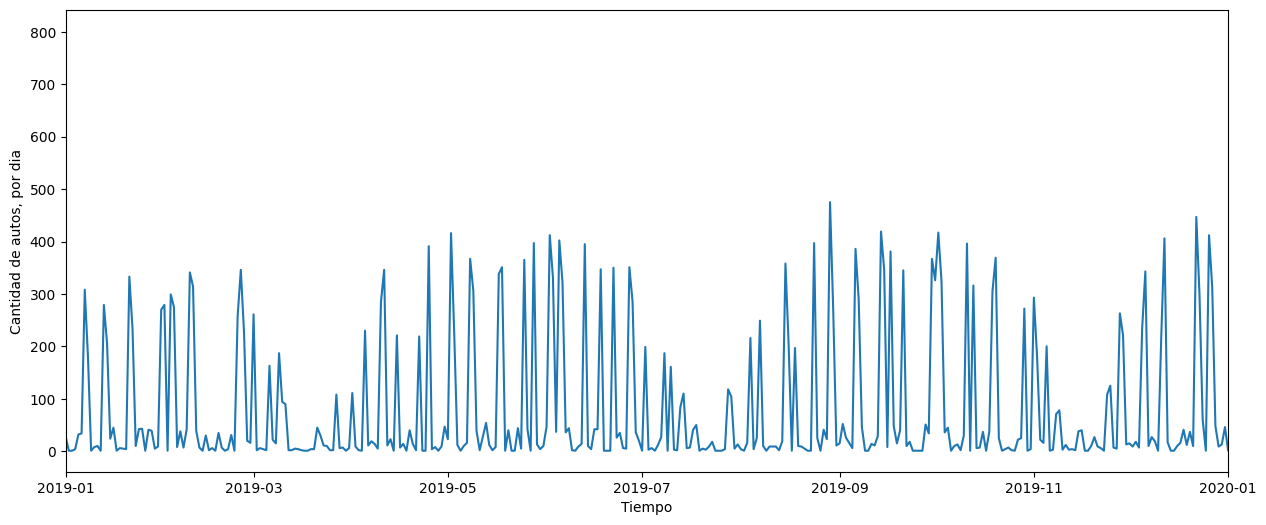

In [112]:
#Volvemos a graficar nuestra serie de tiempo, esta vez por día, y solamente para el año 2021
plt.figure(figsize = (15,6))
plt.plot(data_2021.index, data_2021.cantidad_pasos)
plt.xlim(datetime.date(2019,1,1), datetime.date(2020,1,1))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [113]:
#Concatenamos datos del 2020 y 2021:
data_20_21 = pd.concat([data_2020, data_2021])


In [114]:
data_20_21.shape

(70574, 5)

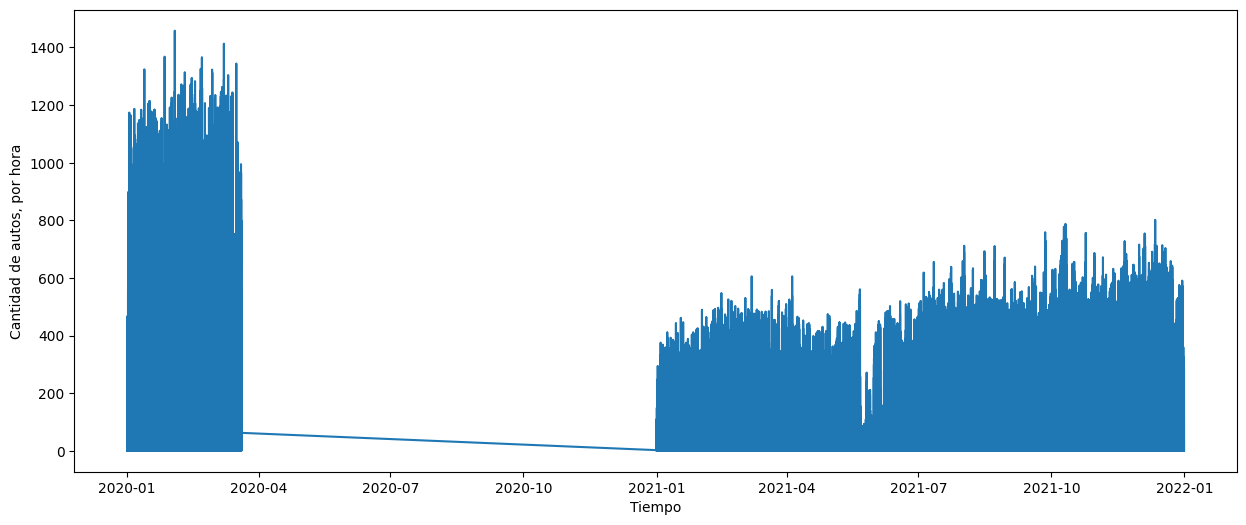

In [115]:
plt.figure(figsize = (15,6))
plt.plot(data_20_21.fecha, data_20_21.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

- se puede ver claramente el vacío de datos por la pandèmia en 2020


In [116]:
diario = data_20_21.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(731, 4)


,dia,sentido,tipo_vehiculo,cantidad_pasos
fecha,,,,
2020-01-01,MiércolesMiércolesMiércolesMiércolesMiércolesM...,CentroProvinciaProvinciaCentroProvinciaCentroP...,Pesados 2 EjesPesados 2 EjesMotoMotoAutoAutoPe...,21395
2020-01-02,JuevesJuevesJuevesJuevesJuevesJuevesJuevesJuev...,ProvinciaCentroProvinciaCentroCentroProvinciaP...,AutoAutoMotoMotoPesados 2 EjesPesados 2 EjesPe...,33722
2020-01-03,ViernesViernesViernesViernesViernesViernesVier...,CentroProvinciaProvinciaCentroProvinciaCentroP...,MotoMotoPago Doble AutoPesados 2 EjesPesados 2...,37067
2020-01-04,SábadoSábadoSábadoSábadoSábadoSábadoSábadoSába...,ProvinciaCentroProvinciaProvinciaProvinciaCent...,Auto con trailerMotoMotoAutoPesados 2 EjesPesa...,30627
2020-01-05,DomingoDomingoDomingoDomingoDomingoDomingoDomi...,ProvinciaCentroCentroProvinciaCentroCentroProv...,AutoAutoPesados 2 EjesPesados 2 EjesPesados 3 ...,27812


In [117]:
diario.drop(columns = ['dia','sentido','tipo_vehiculo',], inplace = True)
diario

,cantidad_pasos
fecha,
2020-01-01,21395
2020-01-02,33722
2020-01-03,37067
2020-01-04,30627
2020-01-05,27812
...,...
2021-12-27,14686
2021-12-28,15709
2021-12-29,16248


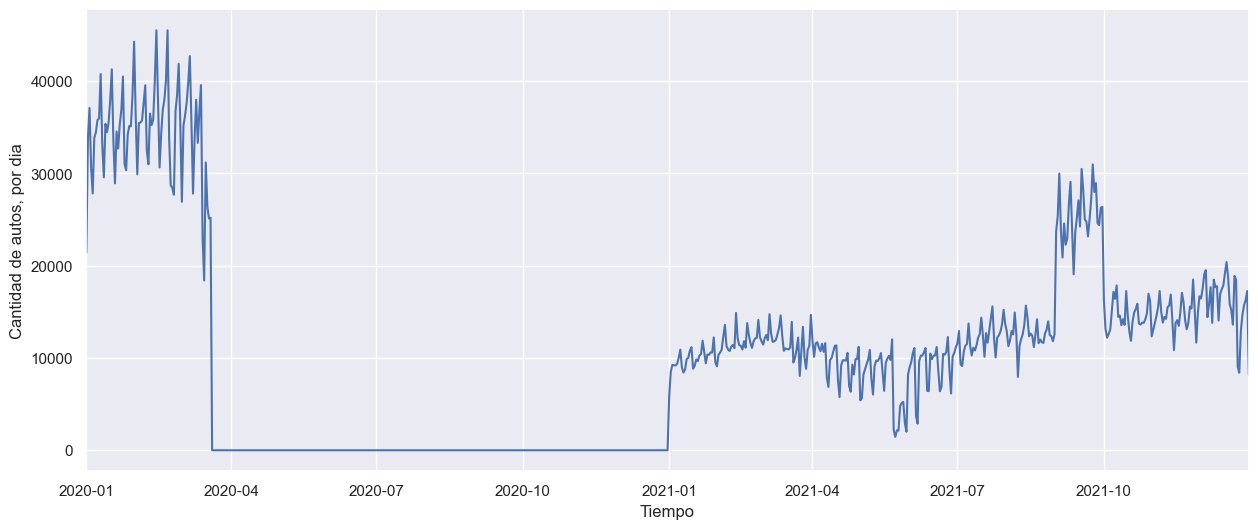

In [124]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim(datetime.date(2020,1,1), datetime.date(2021,12,31))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

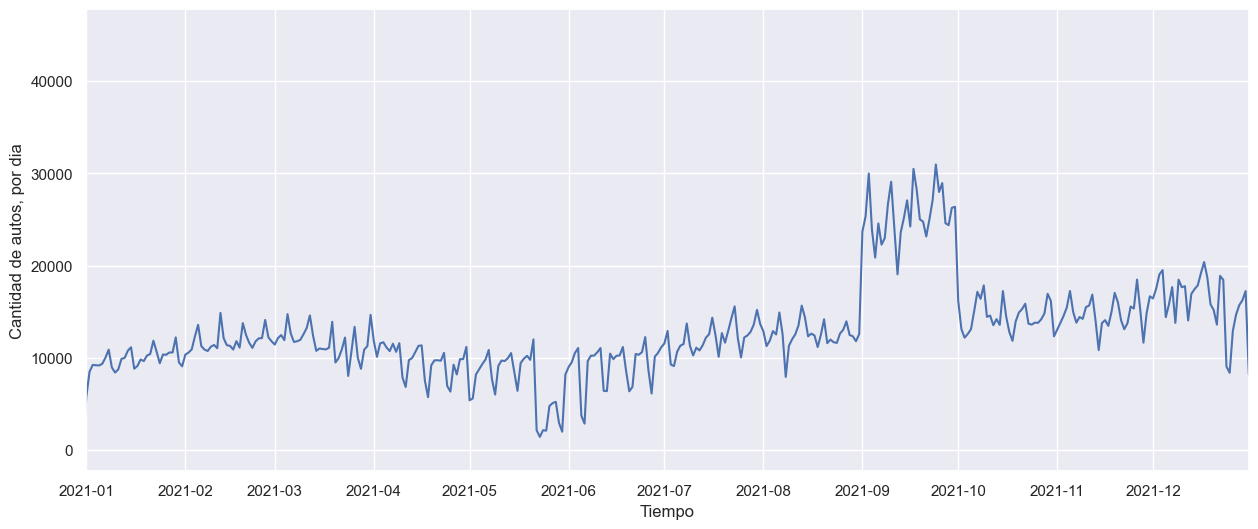

In [125]:
#Cambiando el plot.xlim
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim(datetime.date(2021,1,1), datetime.date(2021,12,31))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [127]:
#Pasamos los datos a frequencia semanal
semanal = data_20_21.resample('W', on = 'fecha').sum()

semanal.drop(columns = ['dia','sentido','tipo_vehiculo',], inplace = True)
print(semanal.shape)
semanal.head()

(105, 1)


,cantidad_pasos
fecha,
2020-01-05,150623
2020-01-12,243359
2020-01-19,246818
2020-01-26,241192
2020-02-02,253335


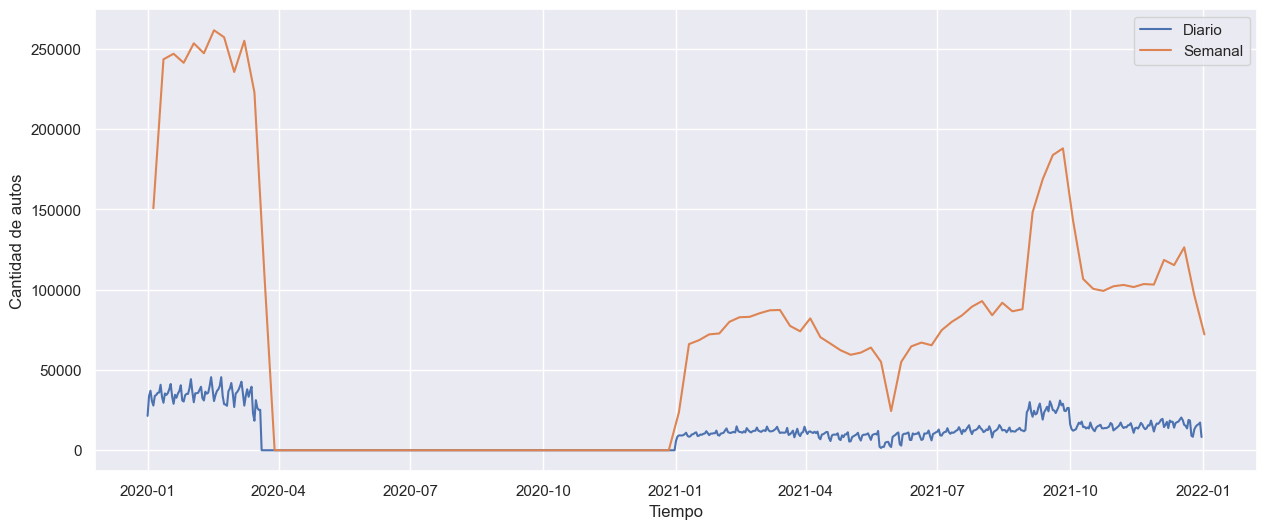

In [128]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos, label = 'Diario')
plt.plot(semanal.index, semanal.cantidad_pasos, label = 'Semanal')
# plt.xlim(datetime.date(2018,1,1), datetime.date(2019,1,1))
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos')
plt.show()

In [129]:
#Agrupamos por horarios usando el promedio:
horario = data_20_21.copy()
horario.drop(columns = ['dia','sentido','tipo_vehiculo',], inplace = True)
hora = pd.DatetimeIndex(horario.fecha)
horario


,cantidad_pasos,fecha
0,1,2020-01-01 00:00:00
1,3,2020-01-01 00:00:00
2,6,2020-01-01 00:00:00
3,7,2020-01-01 00:00:00
4,423,2020-01-01 00:00:00
...,...,...
53853,10,2021-12-31 19:00:00
53854,264,2021-12-31 19:00:00
53855,264,2021-12-31 19:00:00
53856,2,2021-12-31 19:00:00


In [130]:
agrupado_por_horario = horario.groupby(hora.hour).mean()
agrupado_por_horario

,cantidad_pasos,fecha
fecha,,
0,64.386100,2020-08-31 20:30:56.988417024
1,58.559435,2020-08-15 11:11:40.249376512
2,43.672306,2020-08-11 03:42:34.942119168
3,33.710351,2020-08-11 15:49:54.871794944
4,27.628963,2020-08-22 06:02:09.562982144
5,31.128454,2021-03-20 14:55:15.011202304
6,54.955277,2021-04-03 23:14:42.289803008
7,85.561668,2021-03-21 02:04:24.736537344
8,103.642756,2021-03-25 09:56:42.767579648


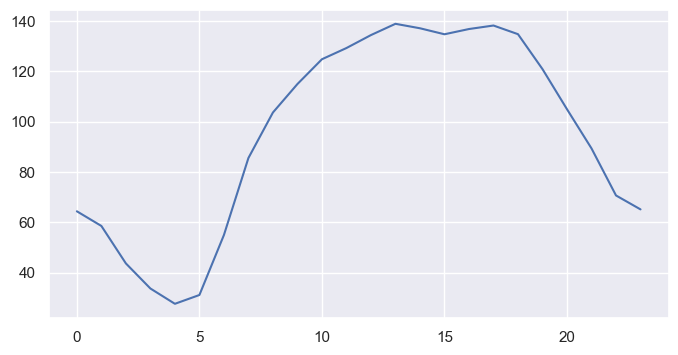

In [131]:
plt.figure(figsize = (8,4))
plt.plot(agrupado_por_horario.index, agrupado_por_horario.cantidad_pasos)
plt.show()

In [132]:
#Rolling window:
diario_promedio = diario.rolling(5, win_type='triang', center=True).mean()
semanal_promedio = semanal.rolling(2, win_type='triang', center=True).mean()

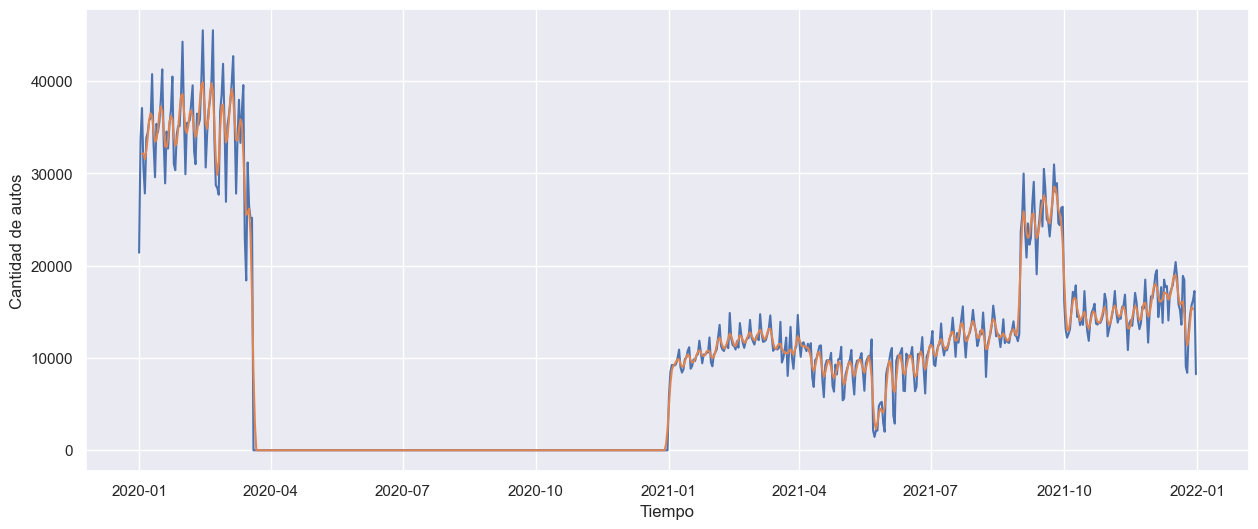

In [133]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos, label = 'Diario')
plt.plot(diario_promedio.index, diario_promedio.cantidad_pasos, label = 'Diario Promedio')
# plt.plot(semanal.index, semanal.cantidad_pasos, label = 'Semanal')
# plt.plot(semanal_promedio.index, semanal_promedio.cantidad_pasos, label = 'Semanal Promedio')
#plt.xlim(datetime.date(2018,1,1), datetime.date(2019,1,1))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos')
plt.show()

In [135]:
#PROPHET:
df = diario.reset_index()
df.rename(columns = {'fecha':'ds', 'cantidad_pasos':'y'}, inplace = True)
df

,ds,y
0,2020-01-01,21395
1,2020-01-02,33722
2,2020-01-03,37067
3,2020-01-04,30627
4,2020-01-05,27812
...,...,...
726,2021-12-27,14686
727,2021-12-28,15709
728,2021-12-29,16248
729,2021-12-30,17242


In [136]:
#Fitear el modelo:
m = Prophet()
m.fit(df)

19:46:17 - cmdstanpy - INFO - Chain [1] start processing
19:46:17 - cmdstanpy - INFO - Chain [1] done processing


In [137]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
1091,2022-12-27
1092,2022-12-28
1093,2022-12-29
1094,2022-12-30
1095,2022-12-31


c:\Users\Elsa\anaconda3\envs\IronHackTest\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Elsa\anaconda3\envs\IronHackTest\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


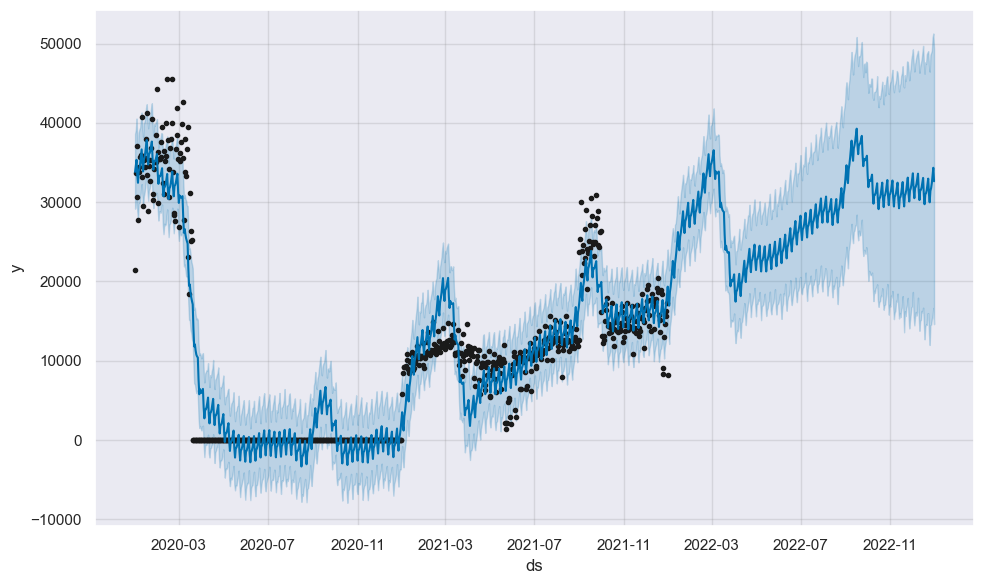

In [138]:
forecast = m.predict(future)
fig1 = m.plot(forecast)

c:\Users\Elsa\anaconda3\envs\IronHackTest\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Elsa\anaconda3\envs\IronHackTest\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\Elsa\anaconda3\envs\IronHackTest\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead 

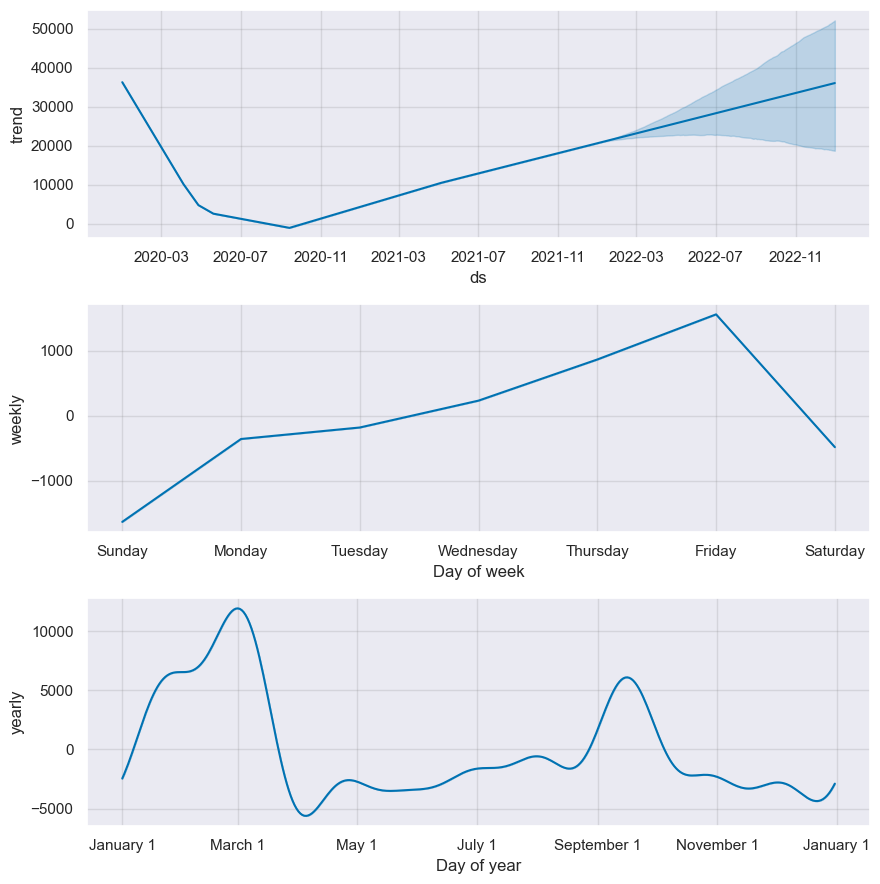

In [139]:
fig2 = m.plot_components(forecast)